# Import trajectory data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date,time,datetime,timedelta
from sklearn import neighbors

import warnings 
warnings.filterwarnings("ignore")

traj_data = pd.read_csv('./all_traj_11_20.csv',parse_dates=['date'],low_memory=False)
traj_data['time'] = pd.to_datetime(traj_data['time'],format= '%H:%M:%S').dt.time
traj_data.head()

,site_id,psy_id,date,time,latitude,longitude
0,1380,20509777,2018-11-20,19:11:50,39.811513,116.573473
1,1380,20509777,2018-11-20,19:12:10,39.811503,116.573433
2,1380,20509777,2018-11-20,19:12:12,39.811473,116.573403
3,1380,20509777,2018-11-20,19:12:14,39.811443,116.573373
4,1380,20509777,2018-11-20,19:12:16,39.811413,116.573363


In [2]:
# remove outliers
lng_lb,lng_ub = np.percentile(traj_data['longitude'],1),np.percentile(traj_data['longitude'],99)
lat_lb,lat_ub = np.percentile(traj_data['latitude'],1),np.percentile(traj_data['latitude'],99)

traj_data = traj_data[(traj_data['longitude']>lng_lb)&
                     (traj_data['longitude']<lng_ub)&
                     (traj_data['latitude']>lat_lb)&
                     (traj_data['latitude']<lat_ub)]
traj_data.head()

,site_id,psy_id,date,time,latitude,longitude
0,1380,20509777,2018-11-20,19:11:50,39.811513,116.573473
1,1380,20509777,2018-11-20,19:12:10,39.811503,116.573433
2,1380,20509777,2018-11-20,19:12:12,39.811473,116.573403
3,1380,20509777,2018-11-20,19:12:14,39.811443,116.573373
4,1380,20509777,2018-11-20,19:12:16,39.811413,116.573363


In [3]:
traj_data.shape

(111930, 6)

# Visualize GIS data

In [4]:
traj = traj_data.iloc[:500,:]  # due to the limit of Google maps API
import gmplot

gmap = gmplot.GoogleMapPlotter(39.807898,116.527496, 15) # gis coordinates for the courier station in BJ

# GIS trajectory data
gmap.scatter(traj.latitude,traj.longitude, '#FFFF00', size=3, marker=False)
gmap.plot(traj.latitude,traj.longitude, 'cornflowerblue', edgewidth=2.5)

gmap.scatter([39.807898],[116.527496],'#FF4500', size=40, marker=False)

gmap.draw( "./gis_trajectory_all.html" ) 

In [5]:
# total number of shipment bills per courier man per courier station
traj_grp = traj_data.groupby(['site_id','psy_id']).size().reset_index(name='counts')  #.reset_index(drop=True)
traj_grp.head()

,site_id,psy_id,counts
0,603,6273,4709
1,603,16426,3881
2,603,25206,4557
3,603,29037,3760
4,603,77562,2900


Text(0,0.5,'Frequency')

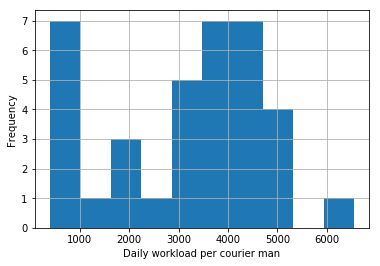

In [6]:
traj_grp['counts'].hist()
plt.xlabel('Total number of GIS records per (site,courier man)')
plt.ylabel('Frequency')

In [7]:
# load a list of courier men info of interest
operr = pd.read_csv('./list_of_operr.csv')
operr = operr[['sta_id','last_rev_operr_id']].reset_index(drop=True)
operr.columns = ['site_id','psy_id']
operr.head()

,site_id,psy_id
0,603,6273
1,603,16426
2,603,25206
3,603,29037
4,603,77562


In [8]:
# number of courier men per station
operr_grp = operr.groupby(['site_id']).size().reset_index(name='counts')
operr_grp

,site_id,counts
0,603,22
1,1380,26


# Join GIS trajectory to courier info list 
## To fiter out those who have insufficient GIS data

In [82]:
sel_traj = pd.merge(operr, traj_data, how='left', on=['site_id', 'psy_id'])
sel_traj = sel_traj.dropna().reset_index(drop=True)
sel_traj.head()

,site_id,psy_id,date,time,latitude,longitude
0,603,6273,2018-11-20,06:50:02,39.821598,116.508775
1,603,6273,2018-11-20,06:50:04,39.821598,116.508835
2,603,6273,2018-11-20,06:50:06,39.821608,116.508895
3,603,6273,2018-11-20,06:50:08,39.821608,116.508964
4,603,6273,2018-11-20,06:50:10,39.821637,116.509064


In [83]:
# total number of shipment bills per selected courier man
sel_traj_grp = sel_traj.groupby(['site_id','psy_id']).size().reset_index(name='counts').sort_values(by=['counts'])
sel_traj_grp.head()

,site_id,psy_id,counts
33,1380,20593335,390
21,1380,294302,395
24,1380,20087664,445
34,1380,20707574,447
31,1380,20537155,634


In [84]:
# finalize courier list
final_operr = sel_traj_grp[['site_id','psy_id']].loc[sel_traj_grp['counts']>100].reset_index(drop=True)
final_operr.head()  # final

,site_id,psy_id
0,1380,20593335
1,1380,294302
2,1380,20087664
3,1380,20707574
4,1380,20537155


In [85]:
# number of courier men per station
final_operr_grp = final_operr.groupby(['site_id']).size().reset_index(name='counts')
final_operr_grp

,site_id,counts
0,603,17
1,1380,19


# Merge the finalized courier info list and its corresponding GIS traj info

In [86]:
traj = pd.merge(final_operr, traj_data, how='left', on=['site_id', 'psy_id'])
traj['datetime'] = [datetime.combine(traj['date'].iloc[i],traj['time'].iloc[i]) for i in range(traj.shape[0])]
traj['dt_sec'] = [(d-datetime(1970,1,1)).total_seconds() for d in traj['datetime']]

traj = traj.dropna().reset_index(drop=True)
traj.head()  # final

,site_id,psy_id,date,time,latitude,longitude,datetime,dt_sec
0,1380,20593335,2018-11-20,18:25:07,39.797645,116.579573,2018-11-20 18:25:07,1.542738e+09
1,1380,20593335,2018-11-20,18:24:35,39.797555,116.579553,2018-11-20 18:24:35,1.542738e+09
2,1380,20593335,2018-11-20,18:23:35,39.797804,116.579962,2018-11-20 18:23:35,1.542738e+09
3,1380,20593335,2018-11-20,18:23:05,39.797884,116.579862,2018-11-20 18:23:05,1.542738e+09
4,1380,20593335,2018-11-20,18:22:35,39.797945,116.579333,2018-11-20 18:22:35,1.542738e+09


In [87]:
# total number of shipment bills per courier man
traj_grp = traj.groupby(['site_id','psy_id']).size().reset_index(name='counts')  #.reset_index(drop=True)
traj_grp.head()

,site_id,psy_id,counts
0,603,6273,4709
1,603,16426,3881
2,603,25206,4557
3,603,29037,3760
4,603,77562,2900


Text(0,0.5,'frequency')

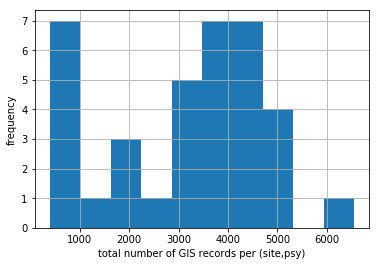

In [88]:
traj_grp['counts'].hist()
plt.xlabel('Total number of GIS records per (site,courier man)')
plt.ylabel('Frequency')

# Recover sequence of shipment data based on GIS data
## 'delv_tm' is not reliable
## infer correct timestamp from GIS trajectory based on the nearest neighbor

In [112]:
bill_data = pd.read_csv('./batch_info_120min.csv',
                        parse_dates=['rev_tm','delv_tm','rev_date','start_tm','end_tm'],
                       low_memory=False)  #,index_col=0)

bill_data = bill_data[bill_data['rev_date']=='2018-11-20']
bill_data = bill_data.drop(['Unnamed: 3'], axis=1).reset_index(drop=True)
bill_data.head()

,station_id,courier_id,rev_date,order_id,lng,lat,rev_tm,delv_tm,batch_id,start_tm,end_tm
0,603,6273,2018-11-20,81813856753,116.50846,39.80072,2018-11-20 08:03:06,2018-11-20 10:57:49,0.0,2018-11-20 08:14:31,2018-11-20 10:58:35.400
1,603,6273,2018-11-20,82221924650,116.50846,39.80072,2018-11-20 08:03:19,2018-11-20 10:28:36,0.0,2018-11-20 08:14:31,2018-11-20 10:58:35.400
2,603,6273,2018-11-20,82220775023,116.50846,39.80072,2018-11-20 08:03:37,2018-11-20 10:44:14,0.0,2018-11-20 08:14:31,2018-11-20 10:58:35.400
3,603,6273,2018-11-20,82221225774,116.50652,39.80238,2018-11-20 08:04:25,2018-11-20 09:14:42,0.0,2018-11-20 08:14:31,2018-11-20 10:58:35.400
4,603,6273,2018-11-20,VB47127407961,116.50652,39.80238,2018-11-20 08:04:52,2018-11-20 09:10:51,0.0,2018-11-20 08:14:31,2018-11-20 10:58:35.400


In [113]:
bill_data.shape

(3234, 11)

In [114]:
# remove outliers for each station
bill_hxy = bill_data[bill_data['station_id']==1380]
bill_yz = bill_data[bill_data['station_id']==603]

lng_lb,lng_ub = np.percentile(bill_hxy['lng'],1),np.percentile(bill_hxy['lng'],99)
lat_lb,lat_ub = np.percentile(bill_hxy['lat'],1),np.percentile(bill_hxy['lat'],99)

bill_hxy = bill_hxy[(bill_hxy['lng']>lng_lb)&
                     (bill_hxy['lng']<lng_ub)&
                     (bill_hxy['lat']>lat_lb)&
                     (bill_hxy['lat']<lat_ub)].reset_index(drop=True)

lng_lb,lng_ub = np.percentile(bill_yz['lng'],1),np.percentile(bill_yz['lng'],99)
lat_lb,lat_ub = np.percentile(bill_yz['lat'],1),np.percentile(bill_yz['lat'],99)

bill_yz = bill_yz[(bill_yz['lng']>lng_lb)&
                     (bill_yz['lng']<lng_ub)&
                     (bill_yz['lat']>lat_lb)&
                     (bill_yz['lat']<lat_ub)].reset_index(drop=True)

bill_data = bill_hxy.append(bill_yz)
bill_data.head()

,station_id,courier_id,rev_date,order_id,lng,lat,rev_tm,delv_tm,batch_id,start_tm,end_tm
0,1380,87935,2018-11-20,81813248789,116.574750,39.806540,2018-11-20 07:56:17,2018-11-20 07:57:19,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800
1,1380,87935,2018-11-20,82219180227,116.574750,39.806540,2018-11-20 08:05:56,2018-11-20 09:12:05,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800
2,1380,87935,2018-11-20,82227753933,116.574750,39.806540,2018-11-20 08:06:02,2018-11-20 09:34:27,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800
3,1380,87935,2018-11-20,82221175745,116.574750,39.806540,2018-11-20 08:06:08,2018-11-20 10:49:48,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800
4,1380,87935,2018-11-20,82039294059,116.573950,39.808420,2018-11-20 08:06:17,2018-11-20 10:18:55,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800
5,1380,87935,2018-11-20,82226746467,116.574753,39.806541,2018-11-20 08:06:26,2018-11-20 08:52:42,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800
6,1380,87935,2018-11-20,82083396107,116.573950,39.808420,2018-11-20 08:07:01,2018-11-20 08:38:23,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800
7,1380,87935,2018-11-20,81815301429,116.574750,39.806540,2018-11-20 08:07:19,2018-11-20 11:14:22,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800
8,1380,87935,2018-11-20,82229876644,116.573950,39.808420,2018-11-20 08:07:32,2018-11-20 08:38:24,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800
9,1380,87935,2018-11-20,82226599822,116.574750,39.806540,2018-11-20 08:08:00,2018-11-20 10:44:40,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800


In [115]:
bill_data.shape

(3095, 11)

# Visualize the raw shipment trajectory with unadjusted sequence

In [117]:
gmap = gmplot.GoogleMapPlotter(39.807898,116.527496, 15) 

# GIS trajectory data
gmap.scatter(bill_data.lat,bill_data.lng, '#FFFF00', size=3, marker=False)
gmap.plot(bill_data.lat,bill_data.lng, 'cornflowerblue', edgewidth=2.5)

#gmap.marker(39.808516, 116.578040,'cornflowerblue',title="A street corner in Seattle")
gmap.scatter([39.807898],[116.527496],'#FF4500', size=40, marker=False)

gmap.draw( "./gis_order_all.html" ) 

In [118]:
# remove those who corresponding to an extreme large batch duration (>8 hours)
bill_data['batch_duration'] = [(bill_data['end_tm'].iloc[i]-bill_data['start_tm'].iloc[i]).total_seconds() 
                           for i in range(bill_data.shape[0])]
courier_to_remove1 = bill_data['courier_id'].loc[bill_data['batch_duration']>=28800]
courier_to_remove1 = courier_to_remove1.unique()

In [119]:
# remove those who corresponding to an extreme small batch duration (<0.5 hours)
bill_data['batch_duration'] = [(bill_data['end_tm'].iloc[i]-bill_data['start_tm'].iloc[i]).total_seconds() 
                           for i in range(bill_data.shape[0])]
courier_to_remove2 = bill_data['courier_id'].loc[bill_data['batch_duration']<=2000]
courier_to_remove2 = courier_to_remove2.unique()

In [121]:
bill_data = bill_data[~bill_data['courier_id'].isin(courier_to_remove1)]
bill_data = bill_data[~bill_data['courier_id'].isin(courier_to_remove2)]

bill_data.head()

,station_id,courier_id,rev_date,order_id,lng,lat,rev_tm,delv_tm,batch_id,start_tm,end_tm,batch_duration
0,1380,87935,2018-11-20,81813248789,116.57475,39.80654,2018-11-20 07:56:17,2018-11-20 07:57:19,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800,9713.8
1,1380,87935,2018-11-20,82219180227,116.57475,39.80654,2018-11-20 08:05:56,2018-11-20 09:12:05,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800,9713.8
2,1380,87935,2018-11-20,82227753933,116.57475,39.80654,2018-11-20 08:06:02,2018-11-20 09:34:27,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800,9713.8
3,1380,87935,2018-11-20,82221175745,116.57475,39.80654,2018-11-20 08:06:08,2018-11-20 10:49:48,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800,9713.8
4,1380,87935,2018-11-20,82039294059,116.57395,39.80842,2018-11-20 08:06:17,2018-11-20 10:18:55,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800,9713.8


In [122]:
cnt_batch = bill_data.groupby(['station_id','courier_id','batch_id']).size().reset_index(name='counts')
cnt_batch.head()

,station_id,courier_id,batch_id,counts
0,603,6273,0.0,53
1,603,6273,1.0,30
2,603,16426,0.0,43
3,603,16426,1.0,26
4,603,25206,0.0,34


In [123]:
bill_data = bill_data.rename(columns={'lng': 'longitude','lat':'latitude'})
bill_data.head()

,station_id,courier_id,rev_date,order_id,longitude,latitude,rev_tm,delv_tm,batch_id,start_tm,end_tm,batch_duration
0,1380,87935,2018-11-20,81813248789,116.57475,39.80654,2018-11-20 07:56:17,2018-11-20 07:57:19,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800,9713.8
1,1380,87935,2018-11-20,82219180227,116.57475,39.80654,2018-11-20 08:05:56,2018-11-20 09:12:05,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800,9713.8
2,1380,87935,2018-11-20,82227753933,116.57475,39.80654,2018-11-20 08:06:02,2018-11-20 09:34:27,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800,9713.8
3,1380,87935,2018-11-20,82221175745,116.57475,39.80654,2018-11-20 08:06:08,2018-11-20 10:49:48,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800,9713.8
4,1380,87935,2018-11-20,82039294059,116.57395,39.80842,2018-11-20 08:06:17,2018-11-20 10:18:55,0.0,2018-11-20 08:23:45,2018-11-20 11:05:38.800,9713.8


In [124]:
# finalize courier list
final_operr = final_operr[~final_operr['psy_id'].isin(courier_to_remove1)]
final_operr = final_operr[~final_operr['psy_id'].isin(courier_to_remove2)]

final_operr = final_operr.reset_index(drop=True)
final_operr.head()

,site_id,psy_id
0,1380,20593335
1,1380,294302
2,1380,20707574
3,1380,20537155
4,1380,20581031


In [125]:
final_operr.shape

(31, 2)

In [127]:
# for a specific day
def adjustSequence(bill,trj,sta,cr):  
# input:
#        1. bill: shipment data
#        2. traj: GIS trajectory
#        3. sta: site id of interest
#        4. cr: courier id of interest
# output: sorted shipment data based on GIS
    
    # shipment and gis data for the current (sta,cr)
    sel_bill = bill[(bill['station_id']==sta)&(bill['courier_id']==cr)]
    sel_trj = trj[(trj['site_id']==sta)&(trj['psy_id']==cr)]
    
    # batch reference
    batch_info = sel_bill[['batch_id','start_tm','end_tm']].drop_duplicates().reset_index(drop=True)

    #########
    # by batch
    #########
    b_num = batch_info['batch_id'].unique()
    sort_bills = pd.DataFrame()
    flag = 0
    for b in b_num:
        # batch time window
        st = batch_info['start_tm'].loc[batch_info['batch_id']==b]
        ed = batch_info['end_tm'].loc[batch_info['batch_id']==b]
        
        # shipment locations for batch b
        bills = sel_bill.loc[sel_bill['batch_id']==b,:]
        X_test = bills[['longitude','latitude']]
        
        # traj within time window of batch b
        train = sel_trj[['longitude','latitude','dt_sec']].loc[(sel_trj['datetime']>=st[b])&
                                                               (sel_trj['datetime']<=ed[b])]
        X_train = train.iloc[:,:-1]
        y_train = train.iloc[:,-1]
        if X_train.shape[0]==0: # gis data for the duration of this batch is missing
            bills['inf_time'] = np.nan
            flag = 1
        else:
            K = 1 # based on the closeset location
            
            model = neighbors.KNeighborsRegressor(n_neighbors = K,algorithm='ball_tree')
            model.fit(X_train, y_train)  #fit the model
            y_pred = model.predict(X_test) #make prediction on test set
            bills['batch_id'] = bills['batch_id']-flag
            bills['inf_time'] = [datetime(1970,1,1)+timedelta(seconds=t) for t in y_pred]
            bills = bills.sort_values(by=['inf_time']).reset_index(drop=True)
            
        if b == 0:
            sort_bills = bills
        else:
            sort_bills = sort_bills.append(bills)
            
    return sort_bills

In [128]:
# try it out with one sample
sta_id = 1380
psy_id = 20537155
res = adjustSequence(bill_data,traj,sta_id,psy_id)  
res.head()

,station_id,courier_id,rev_date,order_id,longitude,latitude,rev_tm,delv_tm,batch_id,start_tm,end_tm,batch_duration,inf_time
0,1380,20537155,2018-11-20,82230092141,116.57475,39.80654,2018-11-20 08:01:54,2018-11-20 08:59:52,0.0,2018-11-20 08:18:02,2018-11-20 11:37:45.100,11983.1,2018-11-20 08:21:41
1,1380,20537155,2018-11-20,82228761958,116.57475,39.80654,2018-11-20 07:56:34,2018-11-20 08:47:47,0.0,2018-11-20 08:18:02,2018-11-20 11:37:45.100,11983.1,2018-11-20 08:21:41
2,1380,20537155,2018-11-20,82227050594,116.57475,39.80654,2018-11-20 08:02:51,2018-11-20 08:47:47,0.0,2018-11-20 08:18:02,2018-11-20 11:37:45.100,11983.1,2018-11-20 08:21:41
3,1380,20537155,2018-11-20,82229958945,116.57475,39.80654,2018-11-20 07:57:00,2018-11-20 08:31:19,0.0,2018-11-20 08:18:02,2018-11-20 11:37:45.100,11983.1,2018-11-20 08:21:41
4,1380,20537155,2018-11-20,81800232731,116.57475,39.80654,2018-11-20 08:05:31,2018-11-20 08:36:06,0.0,2018-11-20 08:18:02,2018-11-20 11:37:45.100,11983.1,2018-11-20 08:21:41


# Adjust the delivery sequence for all selected (station, courier man)

In [129]:
final_batch_info = pd.DataFrame()
for site,psy in list(zip(final_operr['site_id'],final_operr['psy_id'])):
    final_batch_info = final_batch_info.append(adjustSequence(bill_data,traj,site,psy))
final_batch_info.head()

,station_id,courier_id,rev_date,order_id,longitude,latitude,rev_tm,delv_tm,batch_id,start_tm,end_tm,batch_duration,inf_time
0,1380,20593335,2018-11-20,82228671691,116.581060,39.801040,2018-11-20 07:57:44,2018-11-20 10:52:22,0.0,2018-11-20 07:57:44,2018-11-20 10:38:21.600,9637.6,2018-11-20 08:23:33
1,1380,20593335,2018-11-20,81815341117,116.580177,39.798077,2018-11-20 07:57:22,2018-11-20 08:40:07,0.0,2018-11-20 07:57:44,2018-11-20 10:38:21.600,9637.6,2018-11-20 09:04:00
2,1380,20593335,2018-11-20,82220682793,116.580270,39.798080,2018-11-20 07:56:59,2018-11-20 09:39:13,0.0,2018-11-20 07:57:44,2018-11-20 10:38:21.600,9637.6,2018-11-20 09:04:00
3,1380,20593335,2018-11-20,81813574038,116.580269,39.798080,2018-11-20 07:55:05,2018-11-20 09:09:09,0.0,2018-11-20 07:57:44,2018-11-20 10:38:21.600,9637.6,2018-11-20 09:04:00
4,1380,20593335,2018-11-20,81802256626,116.580269,39.798080,2018-11-20 07:54:59,2018-11-20 08:36:05,0.0,2018-11-20 07:57:44,2018-11-20 10:38:21.600,9637.6,2018-11-20 09:04:00


In [130]:
# change columns names for outputting
final_batch_info2 = final_batch_info[['order_id','rev_date','station_id','longitude','latitude','courier_id','start_tm',
                                    'end_tm','batch_id']].dropna()
final_batch_info2.columns = ['order_id','create_dt','station_id','lng','lat','courier_id','start_tm','end_tm',
                            'batch_id']
# adjust data format
final_batch_info2['batch_id'] = final_batch_info2['batch_id'].astype(int)
final_batch_info2['start_tm'] = [(final_batch_info2['start_tm'].iloc[i]-datetime(2018,11,20)).total_seconds() 
                                for i in range(final_batch_info2.shape[0])]
final_batch_info2['end_tm'] = [(final_batch_info2['end_tm'].iloc[i]-datetime(2018,11,20)).total_seconds() 
                                for i in range(final_batch_info2.shape[0])]

final_batch_info2 = final_batch_info2.reset_index(drop=True)
final_batch_info2.head()

,order_id,create_dt,station_id,lng,lat,courier_id,start_tm,end_tm,batch_id
0,82228671691,2018-11-20,1380,116.581060,39.801040,20593335,28664.0,38301.6,0
1,81815341117,2018-11-20,1380,116.580177,39.798077,20593335,28664.0,38301.6,0
2,82220682793,2018-11-20,1380,116.580270,39.798080,20593335,28664.0,38301.6,0
3,81813574038,2018-11-20,1380,116.580269,39.798080,20593335,28664.0,38301.6,0
4,81802256626,2018-11-20,1380,116.580269,39.798080,20593335,28664.0,38301.6,0


In [131]:
final_batch_info2.shape

(2501, 9)

In [132]:
#final_batch_info2['create_dt'] = 1
final_batch_info2['start_tm'] = final_batch_info2['start_tm'].astype(int)
final_batch_info2['end_tm'] = final_batch_info2['end_tm'].astype(int)
#final_batch_info.drop('inf_time',axis=1)
final_batch_info2.to_csv('shipment_bill_batch_sorted.csv',index=False)

# Check patterns of adjusted delivery orders

In [133]:
new_batch_info = final_batch_info[['batch_id','start_tm','end_tm']].drop_duplicates().reset_index(drop=True)
new_batch_info.head()

,batch_id,start_tm,end_tm
0,0.0,2018-11-20 07:57:44,2018-11-20 10:38:21.600
1,1.0,2018-11-20 17:02:55,2018-11-20 19:24:24.800
2,0.0,2018-11-20 08:17:38,2018-11-20 11:19:28.000
3,1.0,2018-11-20 17:04:26,2018-11-20 19:01:13.500
4,0.0,2018-11-20 08:18:02,2018-11-20 11:37:45.100


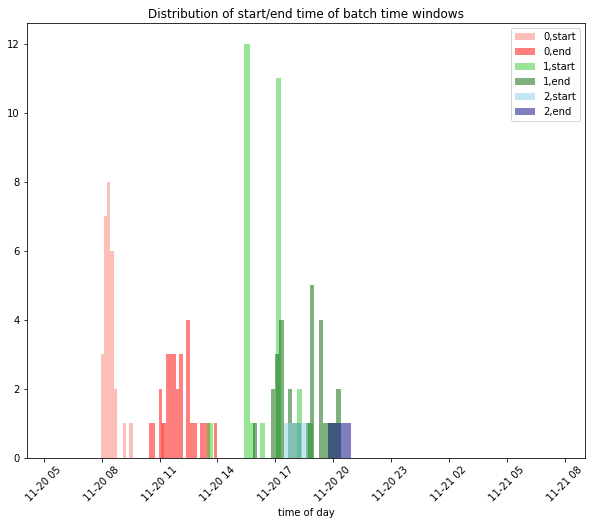

In [134]:
import seaborn as sns

new_batch_0 = new_batch_info[['start_tm','end_tm']][new_batch_info['batch_id']==0]
new_batch_1 = new_batch_info[['start_tm','end_tm']][new_batch_info['batch_id']==1]
new_batch_2 = new_batch_info[['start_tm','end_tm']][new_batch_info['batch_id']==2]

plt.figure(figsize=(10,8))
plt.hist(new_batch_0['start_tm'],bins=20,alpha=0.5,color='#FA8072',label='0,start')
plt.hist(new_batch_0['end_tm'],bins=20,alpha=0.5,color='#FF0000',label='0,end')
plt.hist(new_batch_1['start_tm'],bins=20,alpha=0.5,color='#32CD32',label='1,start')
plt.hist(new_batch_1['end_tm'],bins=20,alpha=0.5,color='#006400',label='1,end')
plt.hist(new_batch_2['start_tm'],bins=20,alpha=0.5,color='skyblue',label='2,start')
plt.hist(new_batch_2['end_tm'],bins=20,alpha=0.5,color='navy',label='2,end')
plt.xlabel('Time of day')
plt.legend()
plt.xticks(rotation=45)
plt.title('Distribution of start/end time of batch time windows')

plt.show()

In [135]:
df_duration = new_batch_0
df_duration.append(new_batch_1)
df_duration.append(new_batch_2)
df_duration['duration'] = [(df_duration['end_tm'].iloc[i]-df_duration['start_tm'].iloc[i]).total_seconds() 
                           for i in range(df_duration.shape[0])]
df_duration.head()

,start_tm,end_tm,duration
0,2018-11-20 07:57:44,2018-11-20 10:38:21.600,9637.6
2,2018-11-20 08:17:38,2018-11-20 11:19:28.000,10910.0
4,2018-11-20 08:18:02,2018-11-20 11:37:45.100,11983.1
6,2018-11-20 08:28:16,2018-11-20 10:25:36.000,7040.0
8,2018-11-20 08:20:26,2018-11-20 13:07:22.400,17216.4


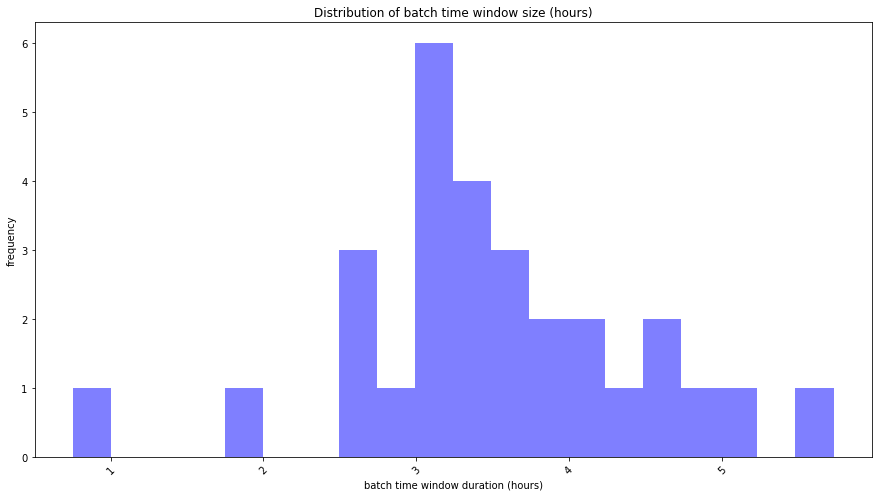

In [136]:
plt.figure(figsize=(15,8))
plt.hist(df_duration['duration']/3600,bins=20,alpha=0.5,color='blue')
plt.xlabel('batch time window duration (hours)')
plt.ylabel('frequency')
plt.xticks(rotation=45)
plt.title('Distribution of batch time window size (hours)')

plt.show()

# Infer average service time from GIS data 

In [137]:
from sklearn.neighbors import NearestNeighbors,KDTree,BallTree

# run for each batch one at a time
def batchServiceTime(r,trj,bill,sta,cr):
    ##
    # 1. r: radius of search
    # 2. traj: daily GIS trajectory data
    # 3. target: all target locations (all batchs of one day)
    
    # parameters
    max_distance = r
    
    # shipment and gis data for the current (sta,cr)
    sel_bill = bill[(bill['station_id']==sta)&(bill['courier_id']==cr)]
    sel_trj = trj[(trj['site_id']==sta)&(trj['psy_id']==cr)]
    
    # batch reference
    batch_info = sel_bill[['batch_id','start_tm','end_tm']].drop_duplicates().reset_index(drop=True)
    
    latlng_grp = sel_bill.groupby(['longitude','latitude','batch_id'])['order_id'].count().reset_index(name='counts')
    latlng_grp = pd.DataFrame(latlng_grp).sort_values(by=['batch_id']).reset_index(drop=True)
    
    ind_of_loc = [i for i in range(latlng_grp.shape[0]) if latlng_grp['counts'].iloc[i]>1]
    target = latlng_grp.loc[ind_of_loc,:].reset_index(drop=True)

    #########
    # by batch
    #########
    b_num = batch_info['batch_id'].unique()
    tot_time = 0
    tot_cnt = 0
    for b in b_num:        
                
        st = batch_info['start_tm'].loc[batch_info['batch_id']==b]
        ed = batch_info['end_tm'].loc[batch_info['batch_id']==b]
        
        train_trj = sel_trj[['longitude','latitude','dt_sec']].loc[(sel_trj['datetime']>=st[b])&
                                                               (sel_trj['datetime']<=ed[b])]
        train_trj['coor'] = list(zip(np.radians(train_trj['latitude']),np.radians(train_trj['longitude'])))
        train_trj = train_trj.reset_index(drop=True)
        
        # training
        points = list(train_trj['coor'])
        if len(points) == 0:
            continue
        else:
            btree = BallTree(points,leaf_size=40,metric='haversine')    
            
            # prediction
            # target points of delivery order locations for this batch
            batch_target = target[target['batch_id']==b]
            
            loc_points = list(zip(np.radians(batch_target['latitude']),np.radians(batch_target['longitude'])))
            #print(len(loc_points))
            #print(neighbors)
            
            if len(loc_points)==0:
                continue
            else:
                neighbors = btree.query_radius(loc_points,r=max_distance,return_distance=False,count_only=False)
                
                time_range = []
                for i in range(len(neighbors)):
                    ind_set = neighbors[i]
                    time_set = train_trj['dt_sec'].iloc[ind_set]
                    if time_set.empty:
                        time_range.append(np.nan)  ############ check this, may need to remove nan before calculating
                    else:
                        time_range.append(max(time_set)-min(time_set))
                        
                cleaned_time_range = [t for t in time_range if str(t) != 'nan']
                batch_time = sum(cleaned_time_range)  # in seconds
                batch_cnt = sum(batch_target['counts'])
                
                tot_time += batch_time
                tot_cnt += batch_cnt
        
    if tot_cnt==0:
        service_tm = np.nan
    else:
        service_tm = tot_time/tot_cnt
        
    return service_tm

In [138]:
r = 0.1/6371 # 100 meters
site_id = 1380
psy_id = 20537155
batchServiceTime(r,traj,bill_data,site_id,psy_id)

733.289156626506

In [139]:
r = 0.075/6371 # 100 meters
service_tm_info = []
for site,psy in list(zip(final_operr['site_id'],final_operr['psy_id'])):
    service_tm_info.append(batchServiceTime(r,traj,bill_data,site,psy))
courier_info = pd.DataFrame({'courier_id':final_operr['psy_id'],
                             'courier_type':1,
                             'service_tm':service_tm_info})
#'site_id':final_operr['site_id'],

In [140]:
# filling nan with median
median_value = courier_info['service_tm'].median()
courier_info['service_tm'] = courier_info['service_tm'].fillna(median_value)

# adjust irregular values
courier_info['service_tm'].loc[courier_info['service_tm']>600] = median_value
courier_info['service_tm'].loc[courier_info['service_tm']<200] = median_value

courier_info.head()

,courier_id,courier_type,service_tm
0,20593335,1,408.775510
1,294302,1,409.259740
2,20707574,1,408.775510
3,20537155,1,431.638554
4,20581031,1,564.589744


In [142]:
courier_info['service_tm'] = 200
courier_info['service_tm'] = courier_info['service_tm'].astype(int)
courier_info.to_csv('courier_info.csv',index=False)

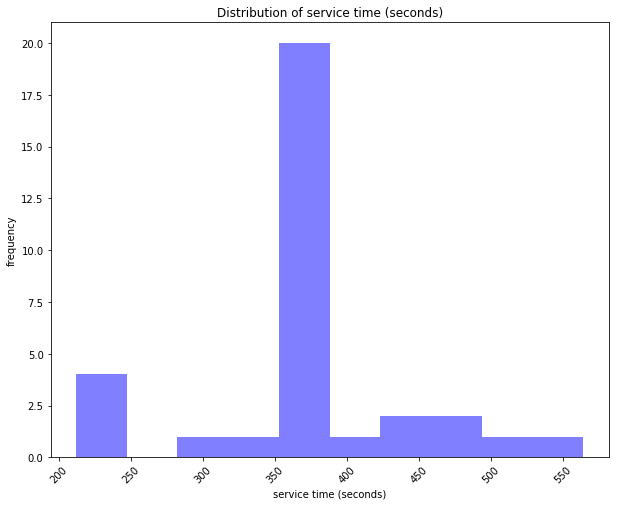

In [54]:
plt.figure(figsize=(10,8))
plt.hist(courier_info['service_tm'],bins=10,alpha=0.5,color='blue')
plt.xlabel('Service time (seconds)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Distribution of service time (seconds)')

plt.show()